In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap, jit
import matplotlib.pyplot as plt
import joblib
from qdots_qll.models import game
from qdots_qll import all_funcs
import seaborn as sns
import pandas as pd
import scipy
from functools import reduce


from matplotlib import rcParams
import matplotlib.font_manager as font_manager

In [6]:
# Add every font at the specified location
# font_dir = ["/Users/darioradecic/Downloads/Merriweather"]
# for font in font_manager.findSystemFonts(font_dir):
#     font_manager.fontManager.addfont(font)

# font_manager.get_font_names()


# rcParams["font.family"] = "Lato"

sns.set_palette("colorblind")

names_true = [
    "$\\gamma ( - \\eta)$",
    "$\\gamma ( + \\eta)$",
    "$S ( - \\eta)$",
    "$S ( +\\eta)$",
]
names_hat = [
    "$\\hat{\\gamma} ( - \\eta)$",
    "$\\hat{\\gamma} ( + \\eta)$",
    "$\\hat{S} ( - \\eta)$",
    "$\\hat{S} ( +\\eta)$",
]

In [7]:
true_parameters = game.true_pars

number_of_samples = 500

iters = np.arange(0, 4000)

In [8]:
# plt.hist(np.array(run_results.times_array).flatten(), bins=200)
# plt.title("Histogram with selected experimental times for 500 runs")
# plt.xlabel("Experimental time (ps)")
# plt.ylabel("Counts")
# plt.show()

In [9]:
def f_to_replace_with_nan(covariances, iteration):
    arr = np.array(covariances)
    arr[iteration + 1 :] = np.nan
    return arr


def return_cov_mse_per_step(results_run, true_parameters, number_of_samples):
    np_cov_arr = np.array(results_run.cov_array)
    np_estimates_arr = np.array(results_run.estimates_array)
    np_iter = np.array(results_run.iteration)

    for i in range(number_of_samples):
        np_cov_arr[i] = f_to_replace_with_nan(np_cov_arr[i], np_iter[i])
        np_estimates_arr[i] = f_to_replace_with_nan(
            np_estimates_arr[i], np_iter[i]
        )

    all_runs_diff_squared = (true_parameters - np_estimates_arr) ** 2

    mse_array_mean = np.nanmean(
        np.nanmean(all_runs_diff_squared, axis=2), axis=0
    )
    mse_array_median = np.nanmedian(
        np.nanmean(all_runs_diff_squared, axis=2), axis=0
    )

    mse_array_std = np.nanstd(
        np.nanmean(all_runs_diff_squared, axis=2), axis=0
    )

    cov_norm_array = jax.vmap(
        lambda a: vmap(jnp.linalg.norm, (0))(a), in_axes=(0)
    )(np_cov_arr)

    cov_norm_array_mean = np.nanmean(cov_norm_array, axis=0)
    cov_norm_array_median = np.nanmedian(cov_norm_array, axis=0)
    cov_norm_array_std = np.nanstd(cov_norm_array, axis=0)

    return [
        [
            cov_norm_array,
            [cov_norm_array_mean, cov_norm_array_median, cov_norm_array_std],
        ],
        [
            all_runs_diff_squared,
            [mse_array_mean, mse_array_median, mse_array_std],
        ],
    ]

In [10]:
def summary_dataframe(
    variances_array, mse_array, times_array, names_true, method
):
    cumulative_times_per_run = (
        vmap(jnp.cumsum, in_axes=(0))(times_array) * 10
    )[:, 1:]

    aux_list = []
    for i in range(500):
        for j in range(4):
            aux_list.append(
                pd.DataFrame(
                    {
                        "Time": cumulative_times_per_run[i],
                        "Variance": variances_array[i, 1:, j],
                        "MSE": mse_array[i, 1:, j],
                        "Parameter": names_true[j],
                        "Run": i,
                    }
                )
            )

    concat_df = pd.concat(aux_list, join="inner").sort_values(by="Time")
    concat_df["Time"] = pd.to_timedelta(concat_df.Time, unit="ns")

    # mean_df = (
    #     concat_df.groupby(
    #         [
    #             concat_df.Time.dt.floor("1000ns"),
    #             concat_df.Parameter,
    #             concat_df.Run,
    #         ]
    #     )
    #     .agg({"Variance": ["mean", "std"], "MSE": ["mean", "std"]})
    #     .reset_index()
    # )

    mean_df = (
        concat_df.groupby(
            [
                concat_df.Time.dt.floor("1000ns"),
                concat_df.Parameter,
                concat_df.Run,
            ]
        )
        .agg({"Variance": "mean", "MSE": "mean"})
        .reset_index()
    )

    mean_df = mean_df[
        (mean_df.Time.dt.total_seconds() <= 5 * 1e5 / (1e9))
        & (mean_df.Time.dt.total_seconds() > 0 / (1e9))
    ]

    mean_df["Method"] = method
    return mean_df

# Det optimized

In [11]:
# Read det optimization

run_results = joblib.load("../results/run_2024-01-22_20:29:42_results.job")
run_model = joblib.load("../results/run_2024-01-22_20:29:42_model.job")


[
    [
        cov_norm_array,
        [cov_norm_array_mean, cov_norm_array_median, cov_norm_array_std],
    ],
    [
        mse_array,
        [mse_array_mean, mse_array_median, mse_array_std],
    ],
] = return_cov_mse_per_step(run_results, true_parameters, number_of_samples)

variances_array = jax.vmap(lambda a: vmap(jnp.diag, (0))(a), in_axes=(0))(
    run_results.cov_array
)

variances_mean = np.nanmean(variances_array, axis=0)
variances_std = np.nanstd(variances_array, axis=0)


mse_indep_mean = np.nanmean(mse_array, axis=0)
mse_indep_std = np.nanstd(mse_array, axis=0)


df_det_optimized = summary_dataframe(
    variances_array,
    mse_array,
    run_results.times_array,
    names_true,
    method="Det optimized",
)

# No time optimization

In [12]:
run_results = joblib.load("../results/run_2024-01-17_11:07:58_results.job")
run_model = joblib.load("../results/run_2024-01-17_11:07:58_model.job")


[
    [
        cov_norm_array,
        [cov_norm_array_mean, cov_norm_array_median, cov_norm_array_std],
    ],
    [
        mse_array,
        [mse_array_mean, mse_array_median, mse_array_std],
    ],
] = return_cov_mse_per_step(run_results, true_parameters, number_of_samples)

variances_array = jax.vmap(lambda a: vmap(jnp.diag, (0))(a), in_axes=(0))(
    run_results.cov_array
)

variances_mean = np.nanmean(variances_array, axis=0)
variances_std = np.nanstd(variances_array, axis=0)


mse_indep_mean = np.nanmean(mse_array, axis=0)
mse_indep_std = np.nanstd(mse_array, axis=0)


df_no_optimization = summary_dataframe(
    variances_array,
    mse_array,
    run_results.times_array,
    names_true,
    method="Non optimized",
)

In [13]:
# We concatenate both df

In [14]:
df_det_optimized.head()

,Time,Parameter,Run,Variance,MSE,Method
2000,0 days 00:00:00.000001,$S ( +\eta)$,0,0.009277,0.011746,Det optimized
2001,0 days 00:00:00.000001,$S ( +\eta)$,1,0.009945,0.001934,Det optimized
2002,0 days 00:00:00.000001,$S ( +\eta)$,2,0.014246,0.002578,Det optimized
2003,0 days 00:00:00.000001,$S ( +\eta)$,3,0.010818,0.004123,Det optimized
2004,0 days 00:00:00.000001,$S ( +\eta)$,4,0.006811,0.004324,Det optimized


In [15]:
total_df = pd.concat([df_det_optimized, df_no_optimization])

In [18]:
def aux_plot(*args, **kwargs):
    x = total_df.Time.dt.total_seconds() * 1e9
    y1 = (lambda a: 300 / a)((total_df.Time.dt.total_seconds() * 1e9))
    y2 = (lambda a: 10000 / a**2)((total_df.Time.dt.total_seconds() * 1e9))

    plt.plot(
        x,
        y1,
        "-.",
        label="SQL $ \\propto 1/ t$",
        alpha=0.7,
    )
    plt.plot(
        x,
        y2,
        "-.",
        label="Heisenberg limit $ \\propto 1/ t^2$",
        alpha=0.7,
    )

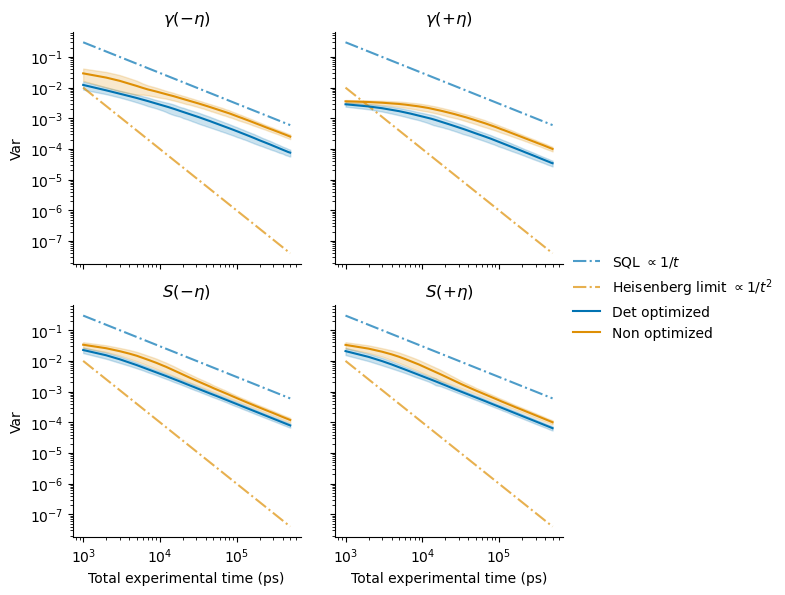

In [21]:
sns.set_palette("colorblind")

g = sns.FacetGrid(
    data=total_df,
    col="Parameter",
    col_wrap=2,
)
g.map_dataframe(aux_plot)

g.map_dataframe(
    sns.lineplot,
    x="Time",
    y="Variance",
    errorbar="sd",
    hue="Method",
)


axes = g.axes.flatten()
for i in range(4):
    axes[i].set_title(names_true[i])
    axes[i].set_ylabel("Var")

g.set_axis_labels("Total experimental time (ps)", y_var="Var")

g.add_legend()

plt.xscale("log")
plt.yscale("log")
plt.show()

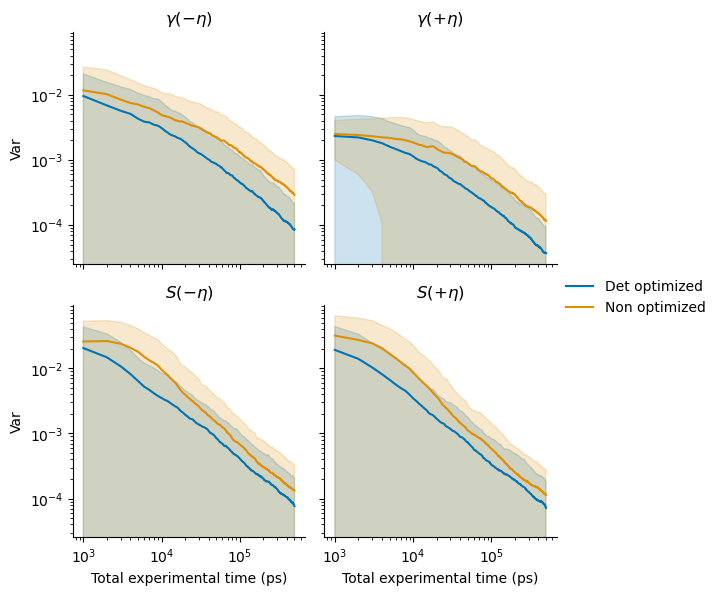

In [22]:
sns.set_palette("colorblind")

g = sns.FacetGrid(
    data=total_df,
    col="Parameter",
    col_wrap=2,
)
# g.map_dataframe(aux_plot)

g.map_dataframe(
    sns.lineplot,
    x="Time",
    y="MSE",
    errorbar="sd",
    hue="Method",
)


axes = g.axes.flatten()
for i in range(4):
    axes[i].set_title(names_true[i])
    axes[i].set_ylabel("Var")

g.set_axis_labels("Total experimental time (ps)", y_var="Var")

g.add_legend()

plt.xscale("log")
plt.yscale("log")
plt.show()